Paul M. Washburn

# Delivery Analysis

This analysis is being undertaken with the over arching goal of finding out whether dropping a truck lease is possible.  The first analysis looks at Saint Louis and Columbia only.  If warranted we will look at Kansas City and Columbia later.

# Data 

There are three sources of data used in this inquiry.  

- The Production Tab of the Daily Report
- Data extract from Hogan containing all of our invoice transactions since 2016 (through April 2018)
- Internal accounting data from the general ledger on Hogan invoices


# Goals

- Characterize the history of deliveyr patterns before/after Schlafly
- Learn about delivery patterns across houses
- Characterize rental costs since 2016 
- Simulate a likely future scenario and account for rental costs

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import glob
import re
import string
from collections import OrderedDict

pd.set_option('max_rows', 99999999)
pd.set_option('max_columns', 99999999)

# Gather Production Tab of Daily Report 2016-2018

In [2]:
def extract_date_stl(file, year):
    '''Takes date from file name'''
    regex_criteria = re.compile(r'[0-9]+-[0-9]+')    
    dat = re.findall(regex_criteria, file)
    exclude = set(string.punctuation)
    dat = ''.join(d for d in dat if d not in exclude)
    dat = str(dat + '-' + year)
    dat = dt.strptime(str(dat), "%m-%d-%Y").date()
    return dat

def extract_stl_production_tab(file, year):
    '''
    Takes in and formats Production Tab from Daily Report. 
    Extracts date from filename and creates index.
    Puts into a dictionary of dataframes 
    for input into a pandas DataFrame.
    '''
    dtypes = {'Date':dt.date, 'Warehouse':str,'LOC':str,'RTE':str,'Driver':str,'Truck#':str,
            'Stops':np.float64,'TTL Cs/splt':np.float64,'Cs':np.float64,'Btls':np.float64,
            'Start Hr':str, 'End Hr':str,'Ttl Hrs':str,'Ttl Mi':np.float64 }
    try:
        df = pd.read_excel(file, sheet_name='Production', converters=dtypes)
    except ValueError:
        df = pd.read_excel(file, sheet_name='Production')        
        
    dat = extract_date_stl(file, year)
    
    df['Date'] = dat 
    df['Month'] = dat.strftime('%B')
    df['Weekday'] = dat.strftime('%A')
    df['WeekNumber'] = dat.strftime('%U')
    df['DOTM'] = dat.strftime('%d')
    df['Warehouse'] = 'STL'
    
    keep_cols = ['Date','Warehouse','LOC','RTE','Driver','Truck#','Stops',
                 'TTL Cs/splt','Cs','Btls','Start Hr',
                 'End Hr','Ttl Hrs','Ttl Mi','Month','Weekday','WeekNumber',
                 'DOTM']
    df = df[keep_cols].drop_duplicates()
    
    WAREHOUSE, ROUTE = df.Warehouse.astype(str), df.RTE.astype(str)
    new_index = WAREHOUSE + '_' + ROUTE 
    
    df.set_index(new_index, inplace=True)
    
    df = df[df['Driver'] != 'Totals:']        
    df = df.sort_values(['Stops','TTL Cs/splt'], ascending=False).reset_index(drop=False)
    
    df['Date'] = df['Date'].replace(to_replace='NaN', value='')
    df = df[df['Date'].isnull() == False]
    
    drop_dumb_shit = lambda col: str(col).lower().replace(' ', '_').replace('#', '').replace('.', '')
    df.columns = [drop_dumb_shit(col) for col in df.columns]
    
    return df

In [3]:
## Update years like on velocity
files_2018 = 'N:\\Daily Report\\2018\\*\\*.xls*'
files_2017 = 'N:\\Daily Report\\2017\\*\\*.xls*'
files_2016 = 'N:\\Daily Report\\2016\\*\\*.xls*'

file_list = {'2016': files_2016, '2017': files_2017, '2018': files_2018}

stl_production = pd.DataFrame()        
for k, v in file_list.items():
    flist = glob.glob(v)
    yr = k
    for file in flist:
        if 'copy' in str(file).lower():
            print('Excluding file:  {}'.format(file))
            pass
        elif '~$' in str(file):
            print('Excluding file:  {}'.format(file))
            pass
        else:
            df  = extract_stl_production_tab(file, year=yr)
            stl_production = stl_production.append(df)
            
stl_production.tail()

Excluding file:  N:\Daily Report\2017\FEB\Copy of 02-20.xlsx
Excluding file:  N:\Daily Report\2017\FEB\Copy of 02-21.xlsx
Excluding file:  N:\Daily Report\2017\MAR\Copy of 03-16.xlsx
Excluding file:  N:\Daily Report\2017\MAY\05-17 COPY.xlsx
Excluding file:  N:\Daily Report\2017\MAY\05-18 - Copy.xlsx
Excluding file:  N:\Daily Report\2017\MAY\Copy of 05-03.xlsx
Excluding file:  N:\Daily Report\2017\MAY\Copy of 05-04.xlsx
Excluding file:  N:\Daily Report\2018\MAR\~$03-21.xlsx
Excluding file:  N:\Daily Report\2018\MAR\~$03-22.xlsx


,index,date,warehouse,loc,rte,driver,truck,stops,ttl_cs/splt,cs,btls,start_hr,end_hr,ttl_hrs,ttl_mi,month,weekday,weeknumber,dotm
48,STL_389,2018-03-29,STL,COL,389,BATES,RT 388,1,101,101.3,41,NaN,NaN,00:00:00,0,March,Thursday,12,29
49,STL_66,2018-03-29,STL,STL,66,0,0,0,0,0,0,NaN,NaN,00:00:00,0,March,Thursday,12,29
50,STL_99,2018-03-29,STL,STL,99,KC TRANSFER,0,0,0,0,0,NaN,NaN,00:00:00,0,March,Thursday,12,29
51,STL_PR,2018-03-29,STL,STL,PR,PRIORITIES,0,0,0,0,0,NaN,NaN,00:00:00,0,March,Thursday,12,29
52,STL_nan,2018-03-29,STL,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,March,Thursday,12,29


In [4]:
ix_cols = ['date', 'warehouse', 'rte']
stl_production.sort_values(ix_cols, inplace=True)
stl_production.set_index(ix_cols, inplace=True, drop=False)

## Offset Date Contained in File Name to Next Day 

The Daily Report is named for the day of routing, not delivery.  To get the correct delivery day the routing date is changed to the delivery date.

In [5]:
stl_production['date'] = stl_production['date'] + pd.to_timedelta(1, unit='d')
stl_production['weekday'] = stl_production['date'].apply(lambda d: d.weekday())
wday_map = dict(zip(np.arange(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
stl_production['weekday'] = stl_production['weekday'].map(wday_map)

## Inspect Routes in Daily Report

In [6]:
print(sorted(stl_production.loc[stl_production['loc']=='STL', 'index'].unique()))

['STL_12', 'STL_13', 'STL_14', 'STL_15', 'STL_152509', 'STL_16', 'STL_17', 'STL_18', 'STL_19', 'STL_20', 'STL_21', 'STL_22', 'STL_23', 'STL_24', 'STL_25', 'STL_26', 'STL_27', 'STL_28', 'STL_29', 'STL_3', 'STL_30', 'STL_301', 'STL_31', 'STL_310', 'STL_311', 'STL_318', 'STL_32', 'STL_33', 'STL_34', 'STL_35', 'STL_36', 'STL_37', 'STL_38', 'STL_39', 'STL_40', 'STL_41', 'STL_43', 'STL_45', 'STL_51', 'STL_53', 'STL_54', 'STL_60', 'STL_61', 'STL_63', 'STL_64', 'STL_65', 'STL_66', 'STL_67', 'STL_68', 'STL_69', 'STL_7', 'STL_70', 'STL_71', 'STL_72', 'STL_73', 'STL_74', 'STL_75', 'STL_76', 'STL_77', 'STL_78', 'STL_79', 'STL_80', 'STL_81', 'STL_82', 'STL_83', 'STL_84', 'STL_85', 'STL_86', 'STL_87', 'STL_88', 'STL_89', 'STL_9', 'STL_90', 'STL_91', 'STL_92', 'STL_93', 'STL_97', 'STL_98', 'STL_99', 'STL_PR']


In [7]:
print(sorted(stl_production.loc[stl_production['loc']=='COL', 'index'].unique()))

['STL_301', 'STL_319', 'STL_320', 'STL_321', 'STL_322', 'STL_323', 'STL_324', 'STL_325', 'STL_326', 'STL_327', 'STL_328', 'STL_330', 'STL_332', 'STL_333', 'STL_334', 'STL_335', 'STL_336', 'STL_337', 'STL_343', 'STL_346', 'STL_347', 'STL_348', 'STL_349', 'STL_350', 'STL_351', 'STL_352', 'STL_353', 'STL_354', 'STL_356', 'STL_358', 'STL_360', 'STL_363', 'STL_364', 'STL_365', 'STL_366', 'STL_367', 'STL_372', 'STL_373', 'STL_376', 'STL_379', 'STL_380', 'STL_381', 'STL_382', 'STL_383', 'STL_384', 'STL_385', 'STL_386', 'STL_387', 'STL_388', 'STL_389', 'STL_390', 'STL_392', 'STL_393', 'STL_394', 'STL_395', 'STL_396', 'STL_397']


## ***Filter Out Non-Routes***

This list was given by Bob Kloeppinger to filter out of the dataset.  Columbia is assumed to send all routes to market.

In [8]:
nontrue_routes = ['STL_70', 'STL_91', 'STL_PR', 'STL_nan', 'STL_90', 'STL_93', 
                  'STL_13', 'STL_3', 'STL_25', 'STL_nan', 'STL_PR', 'STL_90']#['STL_70', 'STL_91', 'STL_PR', 'STL_nan', 'STL_90', 'STL_93', 'STL_13', 'STL_3', 'STL_25']
stl_production['non_true_rtes'] = stl_production['index'].isin(nontrue_routes)

In [9]:
def stl_daily_route_summary(stl_production):
    grpby_df = stl_production.loc[stl_production['loc'].isin(['STL', 'COL'])]
    grpby_df = grpby_df.loc[grpby_df.non_true_rtes == False]
    grp_cols = ['warehouse', 'loc', 'date']
    agg_funcs = {'rte': pd.Series.nunique, 'stops': np.sum, 'ttl_cs/splt': np.sum}
    grpby_df = pd.DataFrame(grpby_df.groupby(grp_cols).agg(agg_funcs)).reset_index(drop=False)
    grpby_df['date'] = pd.to_datetime(grpby_df['date'])
    return grpby_df

stl_daily = stl_daily_route_summary(stl_production)
stl_daily.head()

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'warehouse' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


,warehouse,loc,date,rte,stops,ttl_cs/splt
0,STL,COL,2016-01-04,10,61.0,1744.0
1,STL,COL,2016-01-05,10,119.0,2400.0
2,STL,COL,2016-01-06,12,153.0,2551.0
3,STL,COL,2016-01-07,10,146.0,1822.0
4,STL,COL,2016-01-08,11,177.0,2120.0


## Merge in Calendar Attributes

In [10]:
# merge in calendar data
def generate_calendar(year, drop_index=False):
    '''
    Simple function to generate a calendar containing
    US holidays, weekdays and  holiday weeks.
    '''
    from pandas.tseries.offsets import YearEnd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    start_date = pd.to_datetime('1/1/'+str(year))
    end_date = start_date + YearEnd()
    DAT = pd.date_range(str(start_date), str(end_date), freq='D')
    MO = [d.strftime('%B') for d in DAT]
    holidays = USFederalHolidayCalendar().holidays(start=start_date, end=end_date)

    cal_df = pd.DataFrame({'date':DAT, 'month':MO})
    cal_df['year'] = [format(d, '%Y') for d in DAT]
    cal_df['weekday'] = [format(d, '%A') for d in DAT]
    cal_df['is_weekday'] = cal_df.weekday.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])
    cal_df['is_weekday'] = cal_df['is_weekday'].astype(int)
    cal_df['is_holiday'] = cal_df['date'].isin(holidays)
    cal_df['is_holiday'] = cal_df['is_holiday'].astype(int)
    cal_df['is_holiday_week'] = cal_df.is_holiday.rolling(window=7,center=True,min_periods=1).sum()
    cal_df['is_holiday_week'] = cal_df['is_holiday_week'].astype(int)
    production_days = ['Tuesday','Wednesday','Thursday','Friday']
    cal_df['is_production_day'] = cal_df.weekday.isin(production_days)
    cal_df['is_production_day'] = cal_df['is_production_day'].astype(int)
    last_biz_day = [str(format(dat, '%Y-%m-%d')) 
                    for dat in pd.date_range(start_date, end_date, freq='BM')]
    cal_df['last_selling_day'] = [int(dat in last_biz_day) for dat in cal_df['date'].astype(str)]
    
    if not drop_index: cal_df.set_index('date', inplace=True)
    
    return cal_df

def make_calendars(year_list, drop_index):
    cal_df = pd.DataFrame()
    for year in year_list:
        cal_df = cal_df.append(generate_calendar(year, drop_index=drop_index))
    return cal_df

year_list = ['2016', '2017', '2018']
cal_df = make_calendars(year_list, drop_index=True)

# merge in calendar
stl_daily = stl_daily.merge(cal_df, on='date')
stl_daily.sort_values(['date', 'loc'], inplace=True)
stl_daily.head()

,warehouse,loc,date,rte,stops,ttl_cs/splt,month,year,weekday,is_weekday,is_holiday,is_holiday_week,is_production_day,last_selling_day
0,STL,COL,2016-01-04,10,61.0,1744.0,January,2016,Monday,1,0,1,0,0
1,STL,STL,2016-01-04,21,145.0,6210.0,January,2016,Monday,1,0,1,0,0
2,STL,COL,2016-01-05,10,119.0,2400.0,January,2016,Tuesday,1,0,0,1,0
3,STL,STL,2016-01-05,33,749.0,12176.0,January,2016,Tuesday,1,0,0,1,0
4,STL,COL,2016-01-06,12,153.0,2551.0,January,2016,Wednesday,1,0,0,1,0


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


def plot_tseries_over_group_with_histograms(df, xcol, ycol, grpcol, title_prepend='{}', 
                                            labs=None, x_angle=0, labelpad=60, window=20, 
                                            vertical_col=None, vertical_label='', logy=False):
    '''
    Function for plotting time series df[ycol] over datetime range df[xcol]
    using the unique_grp_vals contained in df[grpcol].unique().  
    
     - df: pd.DataFrame containing datetime and series to plot
     - xcol: str of column name in df for datetime series
     - ycol: str of column name in df for tseries 
     - grpcol: str of column name in df of group over which to plot
     - labs: dict of xlab, ylab
     - title_prepend: str containing "{}" that prepends group names in title
    '''
    unique_grp_vals = df[grpcol].unique()
    nrows = len(unique_grp_vals) // 2
    figsize = (15, 14 * nrows)
    fig, axes = plt.subplots(len(unique_grp_vals), 1, figsize=figsize)
    title_prepend_hist = 'Histogram of ' + str(title_prepend)
    j = 0
    for i, grp in enumerate(unique_grp_vals):
        _df = df.loc[df[grpcol] == grp]
        ax = axes[i]
        ax.plot(_df[xcol], _df[ycol], alpha=.7, color='black', linewidth=0.35)
        ax.plot(_df[xcol], _df[ycol].rolling(window=window, min_periods=min(5, window)).mean(), 
                alpha=.8, color='r', label='{} period rolling avg'.format(window),
                linestyle='--', linewidth=1.5)
        longer_window = int(window * 3)
        ax.plot(_df[xcol], _df[ycol].rolling(window=longer_window, min_periods=5).mean(), 
                alpha=.9, color='darkred', label='{} period rolling avg'.format(longer_window),
                linewidth=2.25)
        mu, sigma = _df[ycol].mean(), _df[ycol].std()
        ax.axhline(mu, linestyle='--', color='r', alpha=.5, linewidth=.3)
        ax.axhline(mu - sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        ax.axhline(mu + sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        ax.set_title(title_prepend.format(grp))
        bottom, top = mu - 3*sigma, mu + 3*sigma
        ax.set_ylim((bottom, top))
        if labs is not None:
            ax.set_xlabel(labs['xlab'])
            ax.set_ylabel(labs['ylab'])
        ax.xaxis.labelpad = labelpad
        ax.xaxis.set_minor_locator(months)
        ax.grid(alpha=.1)
        if x_angle != 0:
            for tick in ax.get_xticklabels():
                tick.set_rotation(x_angle)
        if vertical_col is not None:
            for dat, plotit in zip(_df[xcol], _df[vertical_col]):
                if plotit == 1: 
                    ax.axvline(dat, color='lightblue', alpha=.4, label=vertical_label)
                    vertical_label = ''
        if logy:
            ax.set_yscale('log')
        ax.legend(loc='best')

        divider = make_axes_locatable(ax)
        axHisty = divider.append_axes('right', 1.2, pad=0.1, sharey=ax)
        axHisty.grid(alpha=.1)
        axHisty.hist(_df[ycol].dropna(), orientation='horizontal', alpha=.5, 
                     color='lightgreen', bins=25)
        axHisty.axhline(mu, linestyle='--', color='r', label='mu', 
                        alpha=.5, linewidth=.3)
        axHisty.axhline(mu - sigma, linestyle='-.', color='y', label='+/- two sigma', 
                       alpha=.5, linewidth=.3)
        axHisty.axhline(mu + sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        axHisty.legend(loc='best')
        
        j += 1
                
    sns.set_style("whitegrid")
    sns.despine()
    plt.show()

## Keep Only Production Days & Plot Series

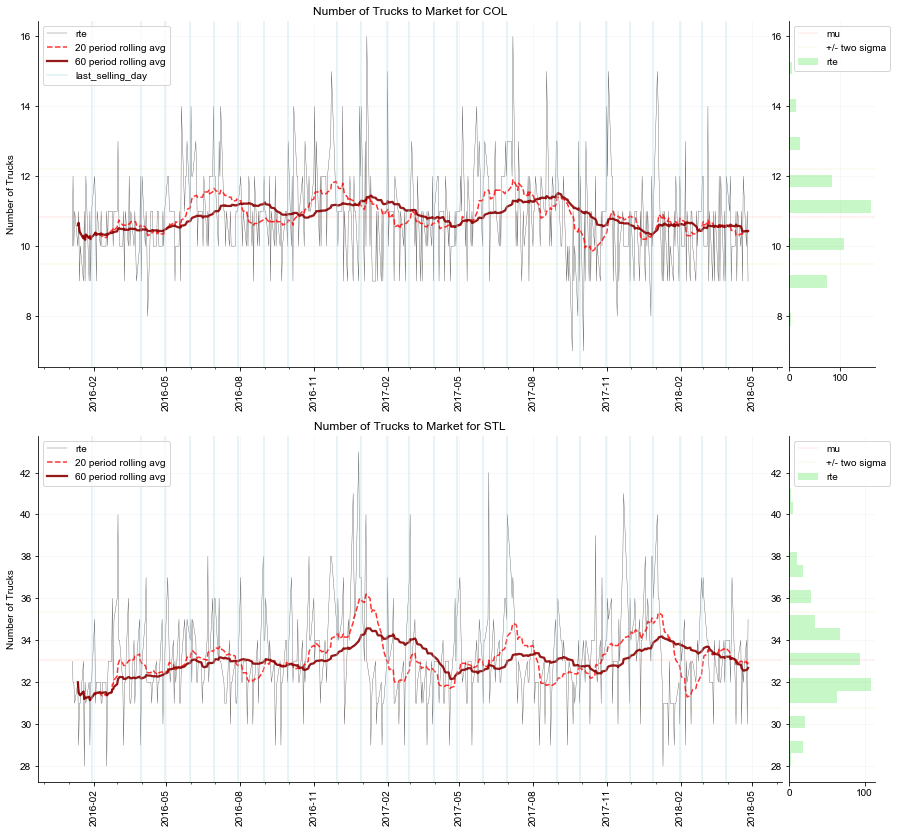

In [12]:
title_prepend = 'Number of Trucks to Market for {}'
xcol = 'date'
ycol = 'rte'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Trucks')
vertical_col = 'last_selling_day'#'is_holiday_week'
vertical_label = 'last_selling_day'#'is_holiday_week'

is_prod_day = stl_daily.is_production_day == True
stl_daily_prdday = stl_daily.loc[is_prod_day]

plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol,
                                       title_prepend, labs, 
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label)

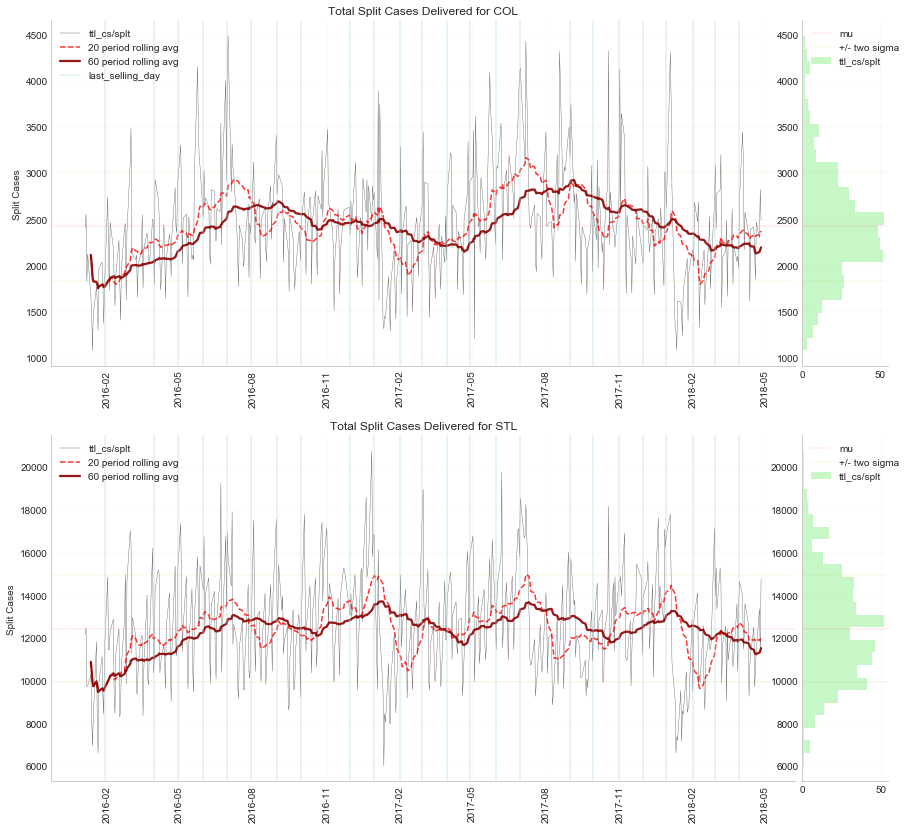

In [13]:
title_prepend = 'Total Split Cases Delivered for {}'
xcol = 'date'
ycol = 'ttl_cs/splt'
grpcol = 'loc'
labs = dict(xlab='', ylab='Split Cases')
    
plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol, title_prepend, labs,  
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label)

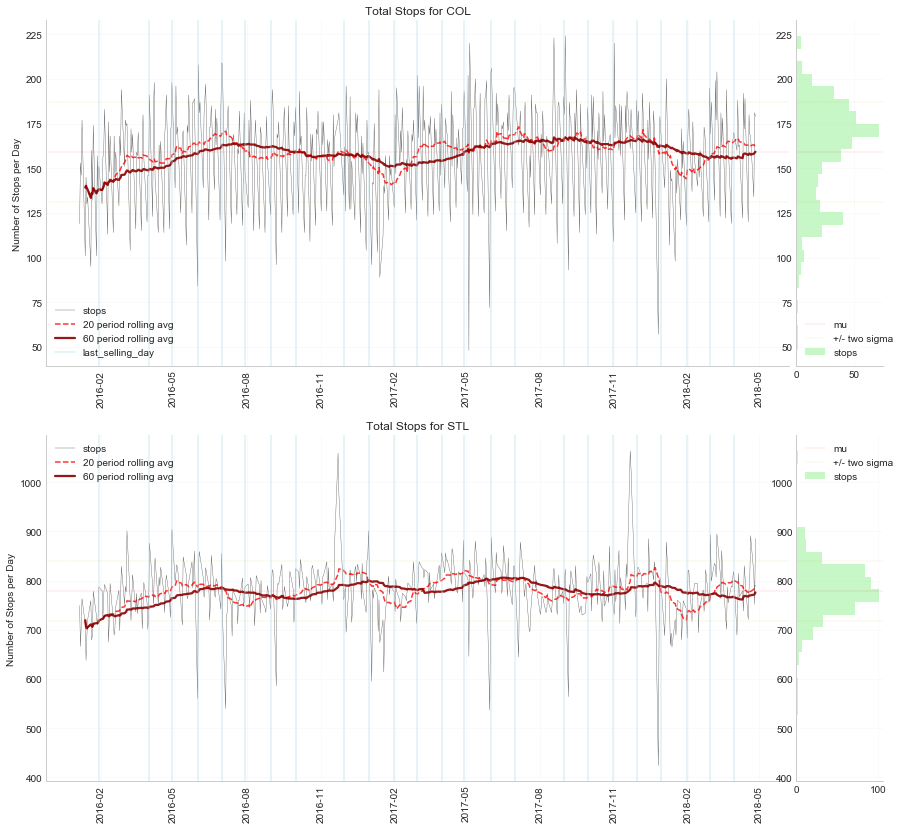

In [14]:
title_prepend = 'Total Stops for {}'
xcol = 'date'
ycol = 'stops'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Stops per Day')

plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol, title_prepend, labs,  
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label)

# Prepare Data for Machine Learning

We need a model that predicts split cases and a model that predicts number of routes.  

In [15]:
# rename columns 
new_colnames = {'rte': 'routes_per_day', 
               'ttl_cs/splt': 'split_cases_delivered_per_day', 
               'stops': 'stops_per_day',
               'loc': 'location'}
stl_daily_prdday.rename(columns=new_colnames, inplace=True)

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [16]:
def preprocess_train_test(df):
    df['date'] = pd.to_datetime(df['date'])
    df['bill_and_hold'] = [int(i) for i in df['date'].dt.day.astype(int) <= 5]
    df['schlafly'] = [int(i) for i in df['date'] <= pd.to_datetime('2018-07-31')]
    
    keep_cols = ['location', 'routes_per_day', 'month', 'date',
                 'split_cases_delivered_per_day', 'stops_per_day', 'weekday', 'year', 
                 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly']
    df = df.loc[:, keep_cols]

    dummy_cols = ['location', 'weekday', 'year', 'month']
    df = pd.get_dummies(df, columns=dummy_cols, drop_first=False)
    drop_space_lowercase = lambda s: str(s).replace(' ', '_').lower()
    df.columns = [drop_space_lowercase(col) for col in df.columns]
    df.reset_index(drop=True, inplace=True)
    return df

df_modeling = preprocess_train_test(stl_daily_prdday)

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

### Split Data to Training & Testing & Scale the Data with `StandardScaler`

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_scale_data(df_modeling, y_col, leave_out, train_size=.8, continuous_cols=[]):
    print('''Using X columns:'''); print(X_cols)
    print('''To predict Y column:'''); print(y_col)
    
    X_train, X_test, y_train, y_test = train_test_split(df_modeling[X_cols], 
                                                        df_modeling[y_col], 
                                                        train_size=train_size)
    if len(continuous_cols) > 0:
        std = StandardScaler()
        std.fit(X_train[continuous_cols].as_matrix())
        X_train[continuous_cols] = std.transform(X_train[continuous_cols])
        X_test[continuous_cols] = std.transform(X_test[continuous_cols])
    else: 
        std = None
    
    return X_train, X_test, y_train, y_test, std

In [18]:
y_col = 'routes_per_day'
leave_out = ['date', 'stops_per_day'] + [y_col] 
X_cols = [col for col in df_modeling.columns if col not in leave_out]

continuous_cols = ['split_cases_delivered_per_day']

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.8,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]
print('Shape X_val: {}, Shape X_test: {}'.format(X_val.shape, X_test.shape))

Using X columns:
['split_cases_delivered_per_day', 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
To predict Y column:
routes_per_day
Shape X_val: (95, 26), Shape X_test: (96, 26)


C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Machine Learning

### Test `RandomForestRegressor` Predicting `routes_per_day`

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.externals import joblib

param_grid = {'n_estimators': np.arange(78, 91, 2),
             'max_features': np.arange(.5, .71, .02)}
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=777,
                              criterion='mse')

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

joblib.dump(grid.best_estimator_, 'rtes_per_day_model_rf.pkl')

grid.best_params_

Train Score = 0.9959464403424548, Validation Score = 0.990414123219587, Test Score = 0.9885317871724968


{'max_features': 0.5, 'n_estimators': 90}

### Test `RandomForestRegressor` to Predict `split_cases_delivered_per_day`

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

y_col = 'split_cases_delivered_per_day'
leave_out = ['date', 'stops_per_day', 'routes_per_day'] + [y_col]
X_cols = [col for col in df_modeling.columns if col not in leave_out]
continuous_cols = []

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.8,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

param_grid = {'n_estimators': np.arange(250, 751, 50),
             'max_features': np.arange(.30, .45, .02)}
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=777,
                              criterion='mse')

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

joblib.dump(grid.best_estimator_, 'splits_per_day_rf.pkl')

grid.best_params_

Using X columns:
['last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
To predict Y column:
split_cases_delivered_per_day


C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train Score = 0.9767282010327712, Validation Score = 0.9299112305283492, Test Score = 0.9416955142009543


{'max_features': 0.4400000000000001, 'n_estimators': 250}

---------------------------------------------------------------------------

---------------

---------------

# Hogan Data

Data below is sent directly from Hogan.

Reindex data so zeros show up for all weekdays not used.  Select for only T-F only in all datasets.

## Read in Data

In [21]:
base_dir = 'N:\\Operations Intelligence\\Operations Research\\Delivery Analysis Post Schlafly\\'
hogan_xlsx = pd.ExcelFile(base_dir + 'FROM HOGAN Rental_Contract_Revenue_Detail.xlsx')
hogan = hogan_xlsx.parse('Rental Contract Revenue Detail', header=0)
hogan['Contract Billing Date'] = hogan['Contract Billing Date'].apply(pd.to_datetime)
hogan_xlsx.close()
hogan.columns = [str(col).replace(' ', '_').lower() for col in hogan.columns]

## Map in Customer Names

In [22]:
cust_id_map = {'001-30000404-000': 'STL', 
               '001-30000406-000': 'SPFD', 
               '001-30000848-000': 'KC', 
               '001-30000884-000': 'COL', 
               '001-30007850-000': 'POS'}
hogan['loc'] = hogan.customer_number.map(cust_id_map) 
hogan = hogan.loc[hogan['loc'] != 'POS']
hogan['loc'].unique()

array(['STL', 'SPFD', 'KC', 'COL'], dtype=object)

## Aggregate by Day and Location

In [23]:
aggfuncs = {'contract__billed_amount': np.sum, 'invoice_number': pd.Series.nunique}
grpcols = ['loc', 'contract_billing_date']
hogan_byday = pd.DataFrame(hogan.groupby(grpcols).agg(aggfuncs)).reset_index(drop=False)
hogan_byday.rename(columns={'contract_billing_date': 'date', 'loc': 'loc'}, inplace=True)
hogan_byday.head()

,loc,date,contract__billed_amount,invoice_number
0,COL,2016-05-27,238.00,1
1,COL,2016-06-07,1228.42,1
2,COL,2016-07-08,1071.00,1
3,COL,2016-07-13,-818.50,1
4,COL,2016-07-15,699.50,1


## Spread Negatives Over Entire Series

In [24]:
def spread_negatives_evenly(df, col):
    below_zero = df[col] < 0
    while np.sum(below_zero) >= 1:
        negs = df.loc[below_zero, col].abs().sum()
        nrow = df.loc[~below_zero, col].shape[0]
        spread = np.divide(negs, nrow)
        df.loc[~below_zero, col] = np.subtract(df.loc[~below_zero, col], spread) 
        df.loc[below_zero, col] = 0
        below_zero = df[col] < 0
    return df

hogan_byday = spread_negatives_evenly(hogan_byday, 'contract__billed_amount')

## Reindex So Missing Dates Represented in Data

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


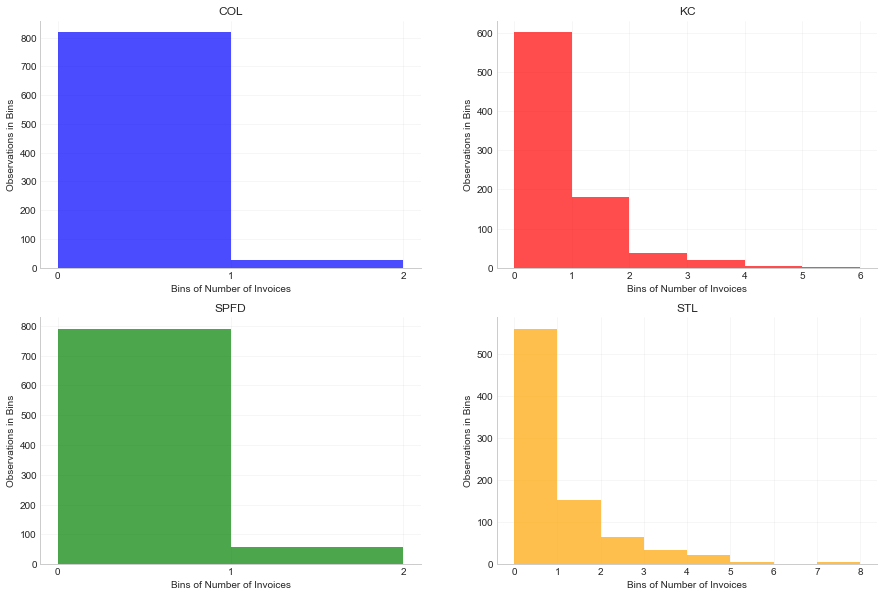

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


contract__billed_amount             invoice_number          
                        mean         std           mean       std
loc                                                              
COL                14.930960   97.181298       0.035461  0.197428
KC                 60.510857  172.426125       0.407801  0.769468
SPFD               25.197369  112.360039       0.069740  0.263983
STL               145.955933  435.419256       0.650118  1.190910

In [25]:
fill_fwd_bwd = lambda df_col: df_col.fillna(method='ffill').fillna(method='bfill')

hogan_daily = pd.DataFrame()
dates = pd.date_range('2016-01-01', '2018-04-25', freq='D')
for grp, df in hogan_byday.groupby('loc'):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True, drop=False)
    df = df.reindex(dates)
    df['loc'] = fill_fwd_bwd(df['loc'])
    df = df.fillna(0)
    df.reset_index(inplace=True)
    df['date'] = df['index']
    df.drop(columns='index', inplace=True)
    hogan_daily = hogan_daily.append(df)
    
import math
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ['blue', 'red', 'green', 'orange']

for i, loc in enumerate(hogan_daily['loc'].unique()):
    if i < 2: ax = axes[0, i]
    else: ax = axes[1, i-2]
    n_invoices = hogan_daily.loc[hogan_daily['loc'] == loc, 'invoice_number']
    ax.hist(n_invoices, 
            bins=int(n_invoices.max()), 
            label='Number of Invoices',
            alpha=.7, color=colors[i])
    ax.set_xlabel('Bins of Number of Invoices')
    ax.set_ylabel('Observations in Bins')
    ax.set_title(str(loc))
    ax.grid(alpha=.2)
    xint = range(0, math.ceil(max(n_invoices)+1))
    ax.set_xticks(xint)
    sns.despine()
sns.set_style('whitegrid')
plt.show()   

agg_funcs = {'contract__billed_amount': {'mean': np.mean, 'std': np.std},
            'invoice_number': {'mean': np.mean, 'std': np.std}}
hogan_daily.groupby('loc').agg(agg_funcs)

--------

--------

--------

# Combine Daily Report and Hogan Data

### Merge Hogan Data into Daily Report Data

Merging in `stl_daily_prdday` which is the Daily Report's Production Tab from 2016-2018.  This particular dataset contains only production days to avoid some of the noise in off-production-day planned delivery days.  

In [26]:
stl_daily_prdday.columns = [str(col).replace(' ', '_').lower() for col in stl_daily_prdday.columns]
stl_daily_prdday.rename(columns={'location': 'loc'}, inplace=True)
stl_daily_prdday['loc'] = stl_daily_prdday['loc'].astype(str)
stl_daily_prdday.set_index(['date', 'loc'], inplace=True)
hogan_daily['loc'] = hogan_daily['loc'].astype(str)
hogan_daily.set_index(['date', 'loc'], inplace=True)

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
hogan_and_daily_rpt = hogan_daily.join(stl_daily_prdday, how='inner')
hogan_and_daily_rpt['amt_per_hogan_invoice'] = np.divide(hogan_and_daily_rpt.contract__billed_amount,
                                                        hogan_and_daily_rpt.invoice_number)
hogan_and_daily_rpt.reset_index(drop=False, inplace=True)

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## Quick Visualization of Combined Data

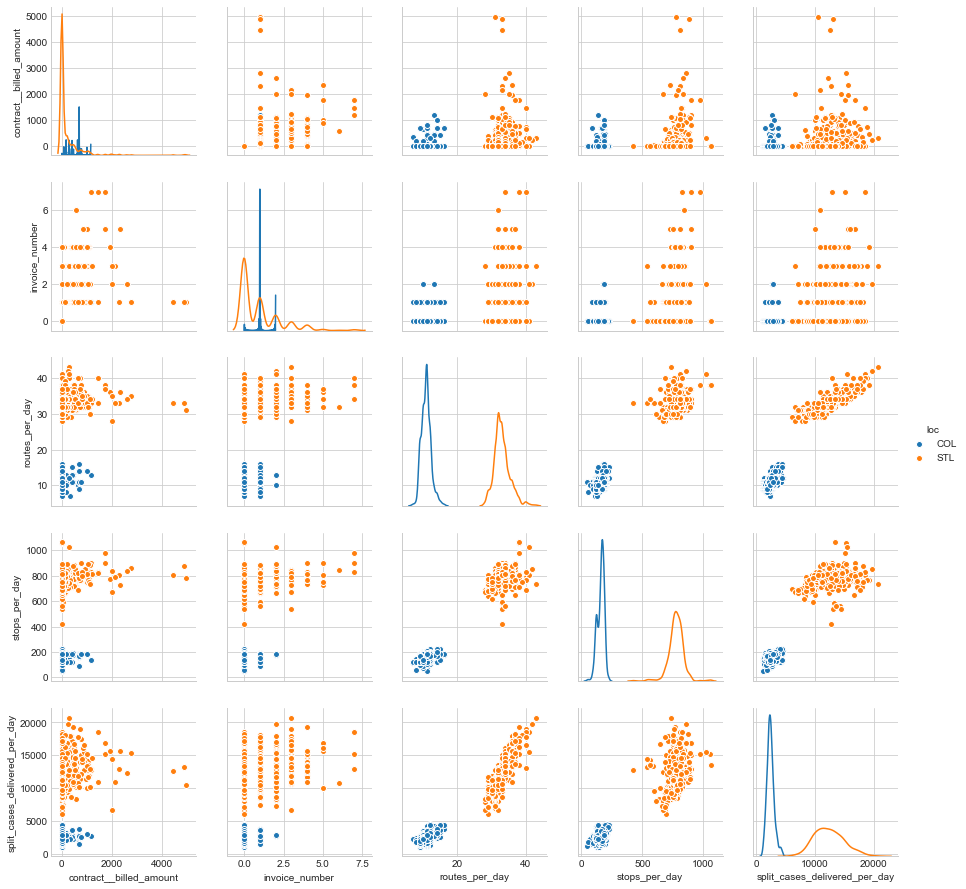

In [28]:
num_cols = ['contract__billed_amount', 'invoice_number', 
            'routes_per_day', 'stops_per_day', 
            'split_cases_delivered_per_day'] #'is_holiday_week', 'last_selling_day'
sns.pairplot(hogan_and_daily_rpt, vars=num_cols, hue='loc', diag_kind='kde')

In [29]:
hogan_and_daily_rpt.groupby('loc')[['amt_per_hogan_invoice', 'invoice_number']].agg([np.mean, np.std])

amt_per_hogan_invoice             invoice_number          
                     mean         std           mean       std
loc                                                           
COL            474.604899  300.005905       0.056723  0.249076
STL            289.986355  613.902664       0.909664  1.288913

------------

------------

------------

------------

# Simulate by Drawing Samples


### Extract Predictions for `splits_forecasted`

First we need to use the baseline model for split cases delivered.  Recall the columns used to predict this data are simply the `cal_df` in this order:

```
['last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
```

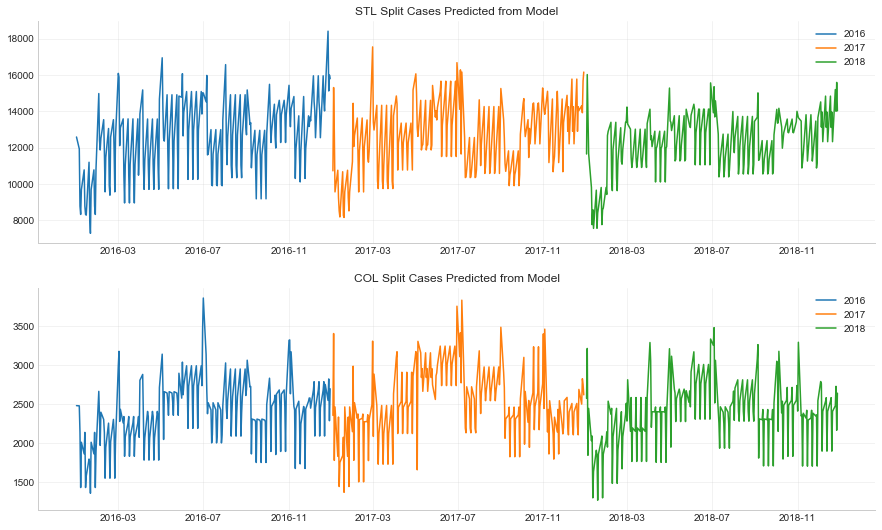

In [30]:
# generate data to predict from
year_list = ['2016', '2017', '2018']
locations = ['STL', 'COL']
predictor_cols = ['last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 
                 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 
                 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 
                 'month_april', 'month_august', 'month_december', 'month_february', 
                 'month_january', 'month_july', 'month_june', 'month_march', 'month_may',
                 'month_november', 'month_october', 'month_september']

def generate_split_model_data(year_list, locations, predictor_cols):
    cal_df = pd.DataFrame()
    for year in year_list:
        for loc in locations:
            _df = generate_calendar(year, drop_index=True)
            _df['location'] = loc
            _df = _df.loc[_df.is_production_day == True]
            cal_df = cal_df.append(_df)
    
    cal_df['date'] = pd.to_datetime(cal_df['date'])
    cal_df['bill_and_hold'] = [int(i) for i in cal_df['date'].dt.day.astype(int) <= 5]
    cal_df['schlafly'] = [int(i) for i in cal_df['date'] <= pd.to_datetime('2018-07-31')]
    
    dummy_cols = ['month', 'year', 'weekday', 'location']
    cal_df = pd.get_dummies(cal_df, dummy_cols, drop_first=False)
    cal_df.columns = [str(col).lower() for col in cal_df.columns]
    dates = cal_df['date']
    cal_df = cal_df[predictor_cols]
    return cal_df, dates

split_model_data, dates = generate_split_model_data(year_list, locations, predictor_cols)

model_splits = joblib.load('splits_per_day_rf.pkl')
split_model_data['splits_forecasted'] = model_splits.predict(split_model_data)
split_model_data['date'] = dates

fig, axes = plt.subplots(2, 1, figsize=(15, 9))
for i, loc in enumerate(locations):
    if loc == 'STL': is_stl = True
    else: is_stl = False
    _df = split_model_data.loc[split_model_data.location_stl == is_stl]
    ax = axes[i]
    is_2016, is_2017 = _df['date'].dt.year == 2016, _df['date'].dt.year == 2017
    is_2018 = (is_2016==False) & (is_2017==False)
    ax.plot(_df.loc[is_2016, 'date'], _df.loc[is_2016, 'splits_forecasted'], label='2016')
    ax.plot(_df.loc[is_2017, 'date'], _df.loc[is_2017, 'splits_forecasted'], label='2017')
    ax.plot(_df.loc[is_2018, 'date'], _df.loc[is_2018, 'splits_forecasted'], label='2018')
    ax.grid(alpha=.3)
    ax.legend(loc='best')
    ax.set_title(str(loc) + ' Split Cases Predicted from Model')
    sns.despine()

### Use Predictions for `split_cases_delivered_per_day` to Predict `routes_per_day`

Recall that the following columns were used as predictors of `routes_per_day`:

```
['split_cases_delivered_per_day', 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
```

We already predicted `routes_per_day`, and have generated the remainder.  We will use this data as predictors.

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


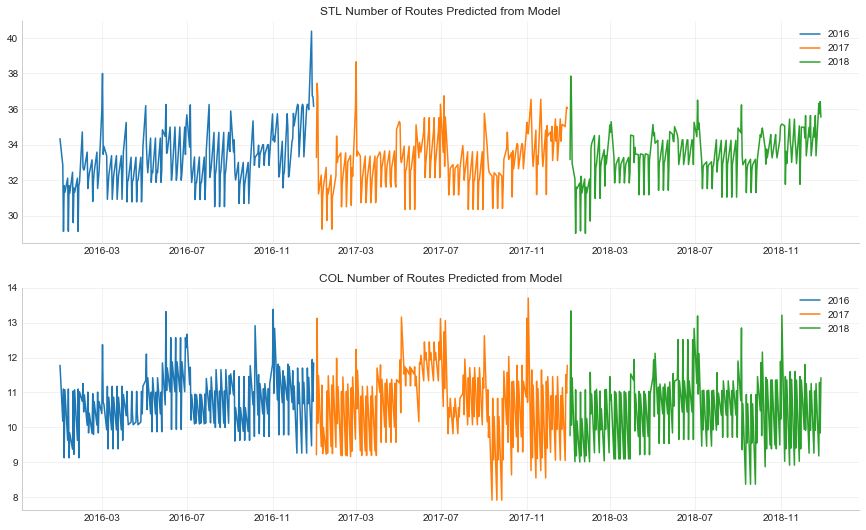

In [31]:
model_rtes = joblib.load('rtes_per_day_model_rf.pkl')

# note splits_forecasted used instead of split_cases_delivered_per_day
predict_cols = ['splits_forecasted', 'last_selling_day', 'is_holiday_week', 
                'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 
                'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 
                'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 
                'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 
                'month_may', 'month_november', 'month_october', 'month_september']

predict_data = split_model_data[predict_cols]
predict_data['splits_forecasted'] = predict_data['splits_forecasted'] - predict_data['splits_forecasted'].mean()
predict_data['splits_forecasted'] = predict_data['splits_forecasted'] / predict_data['splits_forecasted'].std()

split_model_data['rtes_forecasted'] = model_rtes.predict(predict_data)

fig, axes = plt.subplots(2, 1, figsize=(15, 9))
for i, loc in enumerate(locations):
    if loc == 'STL': is_stl = True
    else: is_stl = False
    _df = split_model_data.loc[split_model_data.location_stl == is_stl]
    ax = axes[i]
    is_2016, is_2017 = _df['date'].dt.year == 2016, _df['date'].dt.year == 2017
    is_2018 = (is_2016==False) & (is_2017==False)
    ax.plot(_df.loc[is_2016, 'date'], _df.loc[is_2016, 'rtes_forecasted'], label='2016')
    ax.plot(_df.loc[is_2017, 'date'], _df.loc[is_2017, 'rtes_forecasted'], label='2017')
    ax.plot(_df.loc[is_2018, 'date'], _df.loc[is_2018, 'rtes_forecasted'], label='2018')
    ax.grid(alpha=.3)
    ax.legend(loc='best')
    ax.set_title(str(loc) + ' Number of Routes Predicted from Model')
    sns.despine()

In [32]:
split_model_data.to_excel(base_dir + 'check.xlsx')

## Truck Lease Information

In [44]:
split_model_data.head()

,last_selling_day,is_holiday_week,bill_and_hold,schlafly,location_col,location_stl,weekday_friday,weekday_thursday,weekday_tuesday,weekday_wednesday,year_2016,year_2017,year_2018,month_april,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september,splits_forecasted,date,rtes_forecasted
0,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,12595.668000,2016-01-01,34.333333
4,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11939.110200,2016-01-05,32.844444
5,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8790.780248,2016-01-06,29.122222
6,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8332.713379,2016-01-07,31.688889
7,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9692.248486,2016-01-08,31.311111


In [ ]:
n_leases = {'STL': 28, 'COL': 9}

----------------------

----------------------

----------------------

## Visualize Time Series of Number of Invoices and Amount

In [33]:
hogan_daily.reset_index(drop=False, inplace=True)

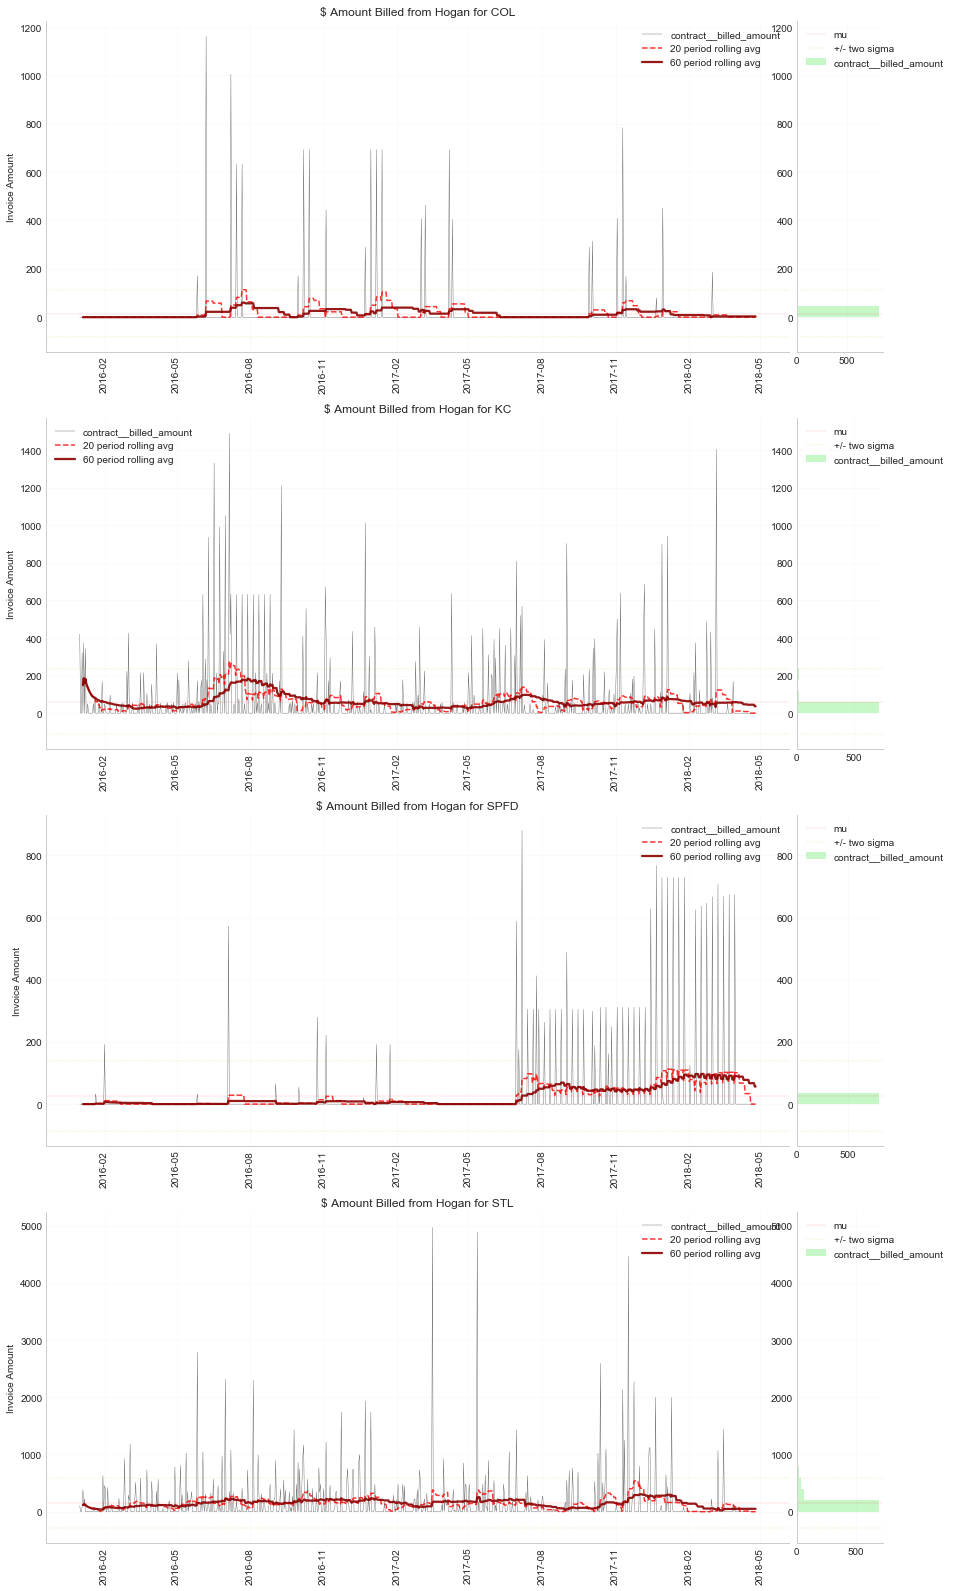

In [43]:
title_prepend = '$ Amount Billed from Hogan for {}'
xcol = 'date'
ycol = 'contract__billed_amount'
grpcol = 'loc'
labs = dict(xlab='', ylab='Invoice Amount')

plot_tseries_over_group_with_histograms(hogan_daily, xcol, ycol, grpcol, 
                                        title_prepend, labs, x_angle=90, logy=False)

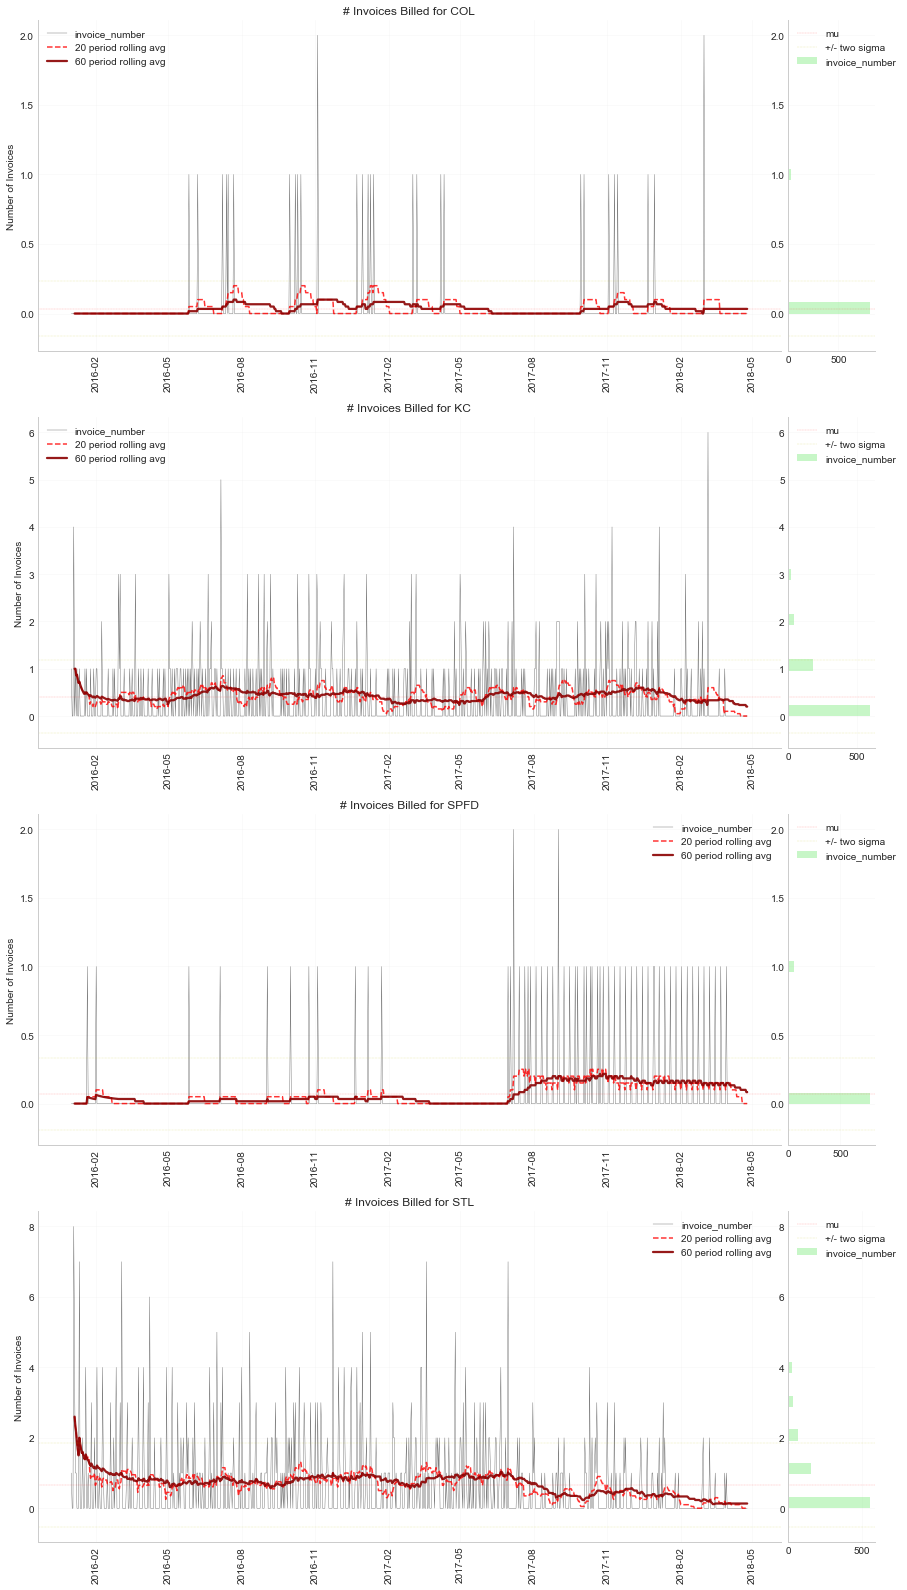

In [35]:
title_prepend = '# Invoices Billed for {}'
xcol = 'date'
ycol = 'invoice_number'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Invoices')

plot_tseries_over_group_with_histograms(hogan_daily, xcol, ycol, grpcol, 
                                        title_prepend, labs, x_angle=90)

------------------

------------------

------------------

# Delivery Equipment Leasing 2016-2018

This data comes directly from the general ledger and is minimally processed.

In [36]:
equip_leasing_xlsx = pd.ExcelFile(base_dir + 'Delivery Equipment Leasing  2016-2018.xlsx')
rentals = equip_leasing_xlsx.parse('All Data', skiprows=4)
rentals.Location = rentals.Location.map({1: 'Kansas City', 2: 'Saint Louis', 3: 'Columbia', 4: 'Springfield'})
rentals.Date = rentals.Date.apply(pd.to_datetime)
equip_leasing_xlsx.close()

In [37]:
aggfuncs = {'Amount': np.sum, 'Reference': pd.Series.nunique}
grpcols = ['Location', 'Date']
rentals_daily = pd.DataFrame(rentals.groupby(grpcols).agg(aggfuncs)).reset_index(drop=False)

In [38]:
pd.pivot_table(rentals_daily, values=['Amount', 'Reference'], columns=['Location'], index='Date')

Amount                                     Reference              \
Location   Columbia Kansas City Saint Louis Springfield  Columbia Kansas City   
Date                                                                            
2016-01-31   929.97     1032.34      390.43     1320.98      31.0        15.0   
2016-02-29  1880.08     1858.25        7.21         NaN      17.0        17.0   
2016-03-31  4029.49     1488.17         NaN        7.52      21.0        14.0   
2016-04-30  2102.05     1353.38      121.02         NaN      12.0         9.0   
2016-05-31  3604.95     2636.30       99.50      238.00      18.0        21.0   
2016-06-30  3095.67     3834.85         NaN     1228.42      14.0        14.0   
2016-07-31  3213.02     6104.33      639.47     1660.94      13.0        17.0   
2016-08-31  3855.68     3771.66        2.89         NaN      23.0        15.0   
2016-09-30   -75.88      873.54      252.91      238.00      23.0        12.0   
2016-10-31  7521.23     2810.22      345.84      811.01      34.0        16.0   
2016-11-30  5022.27     1918.59      181.79      510.44      26.0        17.0   
2016-12-31  9494.56     3432.56       87.66     1117.00      44.0        16.0   
2017-01-31  1273.56      910.84      517.20      181.71      23.0        10.0   
2017-02-28  2980.78     1631.94         NaN         NaN      36.0        14.0   
2017-03-31   927.44     1108.86         NaN     1783.81      35.0        12.0   
2017-04-30  3701.41     1049.89       44.77     1231.32      31.0         7.0   
2017-05-31 -2841.71     1925.50        1.56       19.50      22.0        14.0   
2017-06-30  2820.55     4427.34      798.84         NaN      22.0        18.0   
2017-07-31  2836.37     2310.91     3188.91      122.07      16.0        16.0   
2017-08-31   890.35     2123.35     1072.97         NaN       8.0        12.0   
2017-09-30  7782.03     1093.15     2191.73      377.36      16.0        15.0   
2017-10-31   513.00     1671.63     1282.61      431.90      13.0        17.0   
2017-11-30  4135.13     2341.82     1512.68     1561.08      10.0        18.0   
2017-12-31  5373.60     4172.26     3172.90      153.15      15.0        19.0   
2018-01-31  6345.46     1297.71     2536.03      518.24      12.0        11.0   
2018-02-16    36.30      171.00        3.67       54.82       1.0         1.0   
2018-02-28      NaN      985.18     1649.45       73.89       NaN        10.0   
2018-03-31  7193.76     1562.95     5308.97      270.07      19.0        10.0   

                                    
Location   Saint Louis Springfield  
Date                                
2016-01-31         4.0         2.0  
2016-02-29         1.0         NaN  
2016-03-31         NaN         1.0  
2016-04-30         3.0         NaN  
2016-05-31         1.0         1.0  
2016-06-30         NaN         1.0  
2016-07-31         2.0         5.0  
2016-08-31         1.0         NaN  
2016-09-30         2.0         1.0  
2016-10-31         1.0         2.0  
2016-11-30         3.0         2.0  
2016-12-31         1.0         2.0  
2017-01-31         2.0         3.0  
2017-02-28         NaN         NaN  
2017-03-31         NaN         4.0  
2017-04-30         1.0         2.0  
2017-05-31         2.0         1.0  
2017-06-30         5.0         NaN  
2017-07-31        10.0         1.0  
2017-08-31         3.0         NaN  
2017-09-30         9.0         2.0  
2017-10-31         7.0         2.0  
2017-11-30         4.0         3.0  
2017-12-31         5.0         2.0  
2018-01-31         5.0         1.0  
2018-02-16         1.0         1.0  
2018-02-28         4.0         1.0  
2018-03-31         8.0         3.0

In [39]:
rentals_daily.head()

,Location,Date,Amount,Reference
0,Columbia,2016-01-31,929.97,31
1,Columbia,2016-02-29,1880.08,17
2,Columbia,2016-03-31,4029.49,21
3,Columbia,2016-04-30,2102.05,12
4,Columbia,2016-05-31,3604.95,18


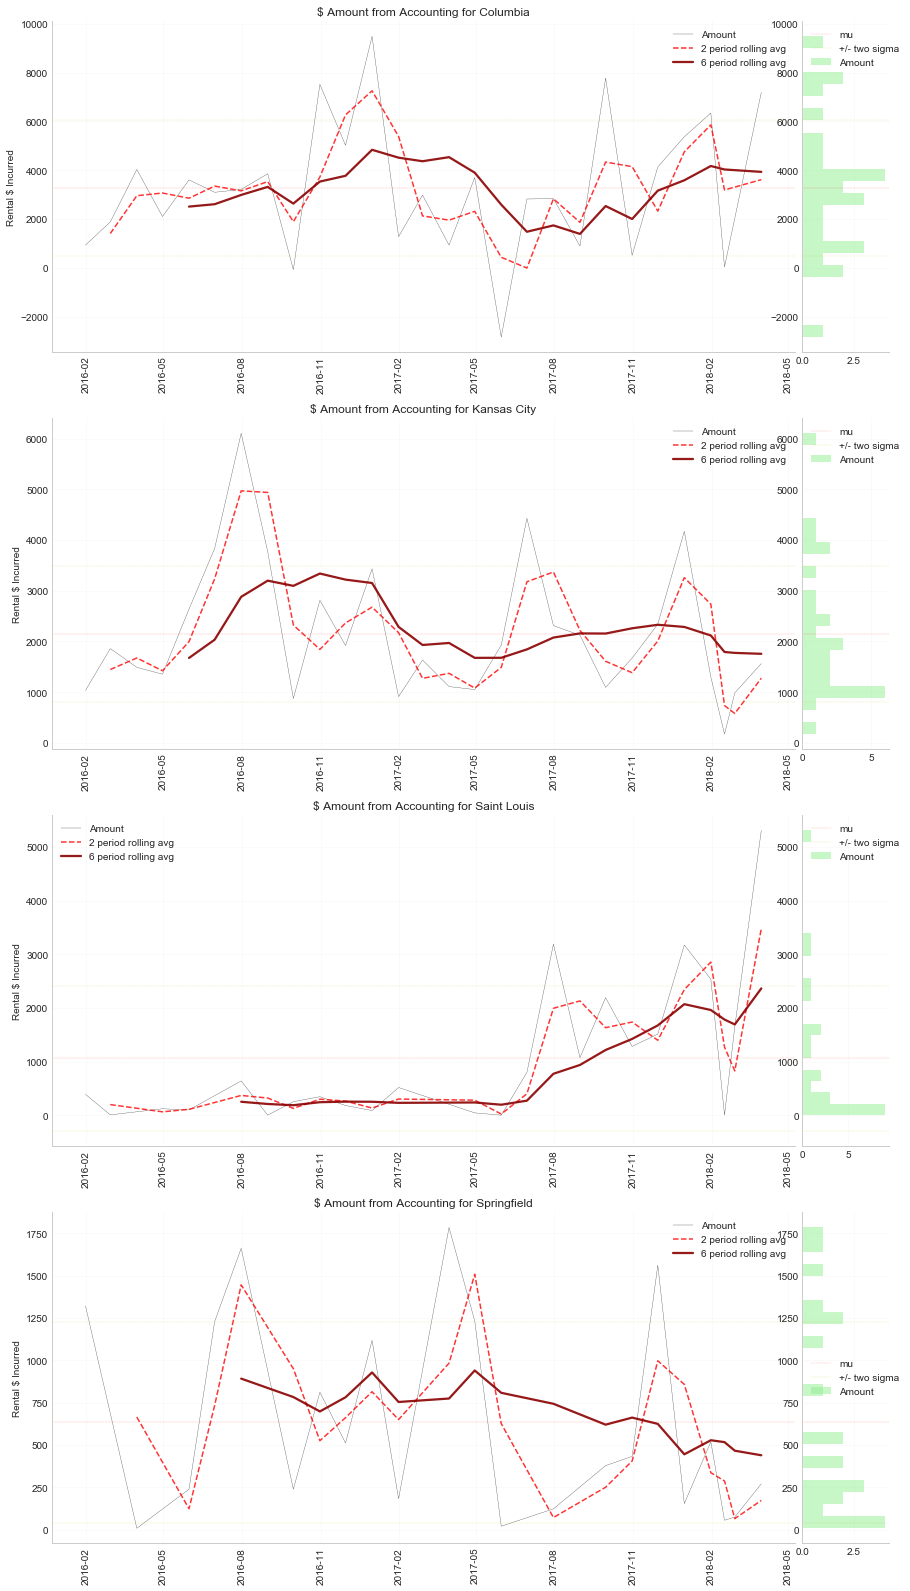

In [40]:
title_prepend = '$ Amount from Accounting for {}'
xcol = 'Date'
ycol = 'Amount'
grpcol = 'Location'
labs = dict(xlab='', ylab='Rental $ Incurred')
    
plot_tseries_over_group_with_histograms(rentals_daily, xcol, ycol, grpcol, 
                                       title_prepend, labs, x_angle=90,
                                       window=2)

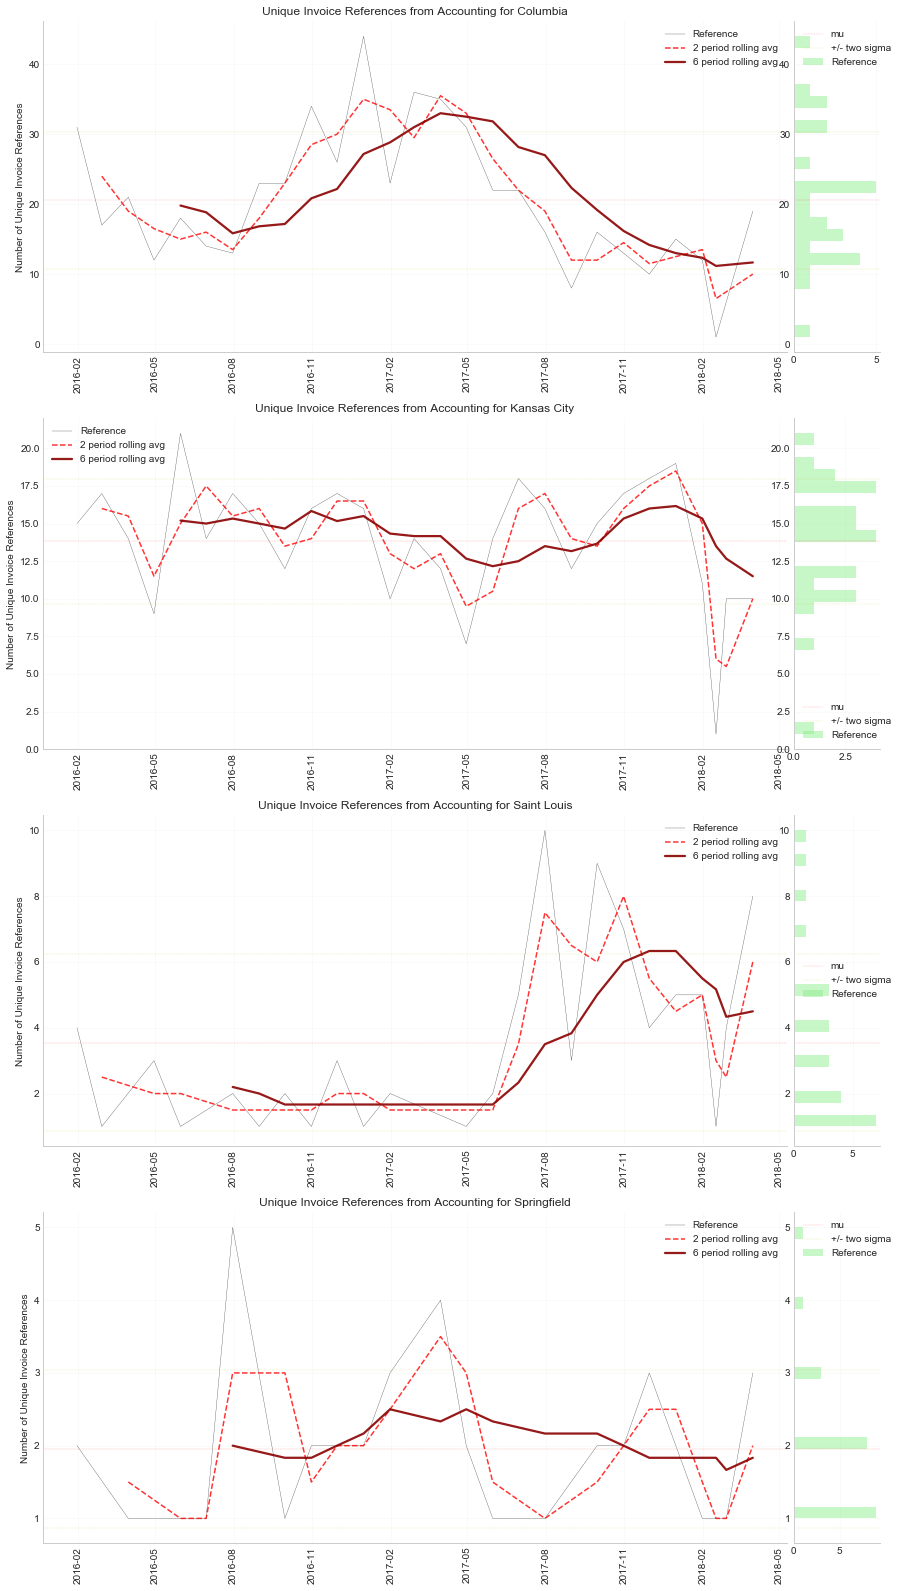

In [42]:
title_prepend = 'Unique Invoice References from Accounting for {}'
labs = dict(xlab='', ylab='Number of Unique Invoice References')
plot_tseries_over_group_with_histograms(rentals_daily, xcol, 'Reference', grpcol, title_prepend, labs, x_angle=90, 
                                        window=2)